#### This notebook is adapted from the simulation notebook for crowding and reading.
#### It simulates data for correlation behavioral data with brain data that has already been collected.
Created June 25th, 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, norm, gmean, sem, median_abs_deviation
import matplotlib.ticker as ticker
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
random.seed(42)

## Functions for noise-correction

In [3]:
def compute_variances(data):
    '''
    takes in n x m dataframe representing n participants and m thresholds (log units)
    
    returns within-participant and across-participant variances
    '''
    
    # Noise: variance within individuals
    within_indiv_var = np.mean(np.var(data, axis = 1, ddof=1))

    # Signal: variance across individuals
    across_indiv_var = np.var(np.mean(data, axis = 1), ddof=1)
    
    return within_indiv_var, across_indiv_var

In [4]:
def compute_noise_ceiling(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    first_half = measurements.iloc[:, :n_measurements//2]
    last_half = measurements.iloc[:, n_measurements//2:]
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_firstLast, _ = pearsonr(np.mean(first_half, axis=1), np.mean(last_half, axis=1))
    r_oddEven, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Compute the split-half reliability as the geometric mean
    r_i = np.sqrt(r_firstLast * r_oddEven)

    # Apply the extrapolation formula for multiple measurements
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

## Compute simulation parameters using pilot data

Load in crowding and RSVP pilot data so that we can compute parameters for our simulation

In [11]:
filepath = 'pilot_multiple_repeats/pilot_multiple_repeats_data/thresholds_clean/'
rsvp = pd.read_csv(filepath + "df_RSVP.csv")
log_rsvp = np.log10(rsvp)

bouma = pd.read_csv(filepath + "df_bouma_avgRL.csv")
log_bouma = np.log10(bouma)
bouma

,0,1,2,3,4,5
0,1.009565,0.983355,0.307521,0.152577,0.224824,0.155160
1,0.386401,0.366750,0.353115,0.368515,0.356702,0.349232
2,0.341063,0.329103,0.441924,0.288346,0.304160,0.280543
3,0.703787,0.377567,0.395850,0.693213,0.606742,0.580936
4,NaN,0.248094,0.188027,0.145038,0.200254,0.267997
5,0.243076,0.135971,0.090413,0.200368,0.412914,0.131651
6,0.543451,0.317962,0.355417,0.214609,0.236423,NaN
7,0.758728,0.652929,0.618407,0.632108,0.576243,0.612862
8,0.200157,0.182626,0.211824,0.151005,0.304035,0.180850
9,0.420669,0.489741,0.353651,0.441011,0.241384,0.281722


In [12]:
def plot_mean_thresholds(df, var_name="Bouma factor", ylims = [0.1, 0.7]):
    """
    Plots mean and median of thresholds across participants for each repeat with error bars
    
    Parameters:
    df (numpy.ndarray or pandas.DataFrame): A dataset where each column represents a different block/repeat
                                               and each row is a participant's data.
    var_name (str): The name of the variable being plotted (used in the title and y-axis label).
    """
    plt.figure(figsize=(8, 6))

    # Shaded patch
    patch_min = 0.18
    patch_max = 0.41
    plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)

    # X-axis positions
    x = np.arange(1, df.shape[1] + 1)

    # Compute statistics
    median_values = np.nanmedian(df, axis=0)
    mean_values = gmean(df, axis=0, nan_policy='omit')

    # Compute error bars
    median_errors = median_abs_deviation(df, axis=0, nan_policy='omit')  # MAD for median
    mean_errors = sem(df, axis=0, nan_policy='omit')  # SEM for mean

    # Plot with error bars
    plt.errorbar(x, median_values, yerr=median_errors, fmt='o-', color='orange', label='Median', capsize=0)
    plt.errorbar(x + .08, mean_values, yerr=mean_errors, fmt='o-', color='red', label='Mean', capsize=0)

    # Formatting
    plt.title(f'Mean {var_name} (N = {bouma.shape[0]})', fontsize=16)
    plt.xlabel('Repeats', fontsize=16)
    plt.xticks(x, size=14)
    plt.ylabel(var_name, fontsize=16)
    plt.legend(fontsize='large')

    # Log scale and tick formatting
    plt.yscale('log')
    plt.yticks(np.linspace(ylims[0], ylims[1], 5), size=14)
    plt.ylim(ylims)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)

    plt.show()

In [13]:
def plot_thresholds(df, var_name="Bouma factor", ylims = [0.08, 1.2]):
    """
    Plots thresholds for each participant across repeats.
    
    Parameters:
    df (pandas.DataFrame or numpy.ndarray): A dataset where each column represents a different repeat,
                                            and each row is a participant's data.
    var_name (str): The name of the variable being plotted (used in the title and y-axis label).
    """
    plt.figure(figsize=(8, 6))

    # Shaded patch
    patch_min = 0.18
    patch_max = 0.41
    plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)

    # X-axis positions
    x = np.arange(1, df.shape[1] + 1)

    # Iterate over rows properly
    for i, row in enumerate(df.values):  # Convert DataFrame to array for iteration
        plt.plot(x, row, marker='o', linestyle='-', label=f'Participant {i+1}')

    # Formatting
    plt.title(f'{var_name} (N = {df.shape[0]})', fontsize=16)
    plt.xlabel('Repeats', fontsize=16)
    plt.xticks(x, size=14)
    plt.ylabel(var_name, fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Log scale and tick formatting
    plt.yscale('log')
    plt.yticks(np.linspace(ylims[0], ylims[1], 5), size=14)
    plt.ylim(ylims)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(False)

    plt.show()

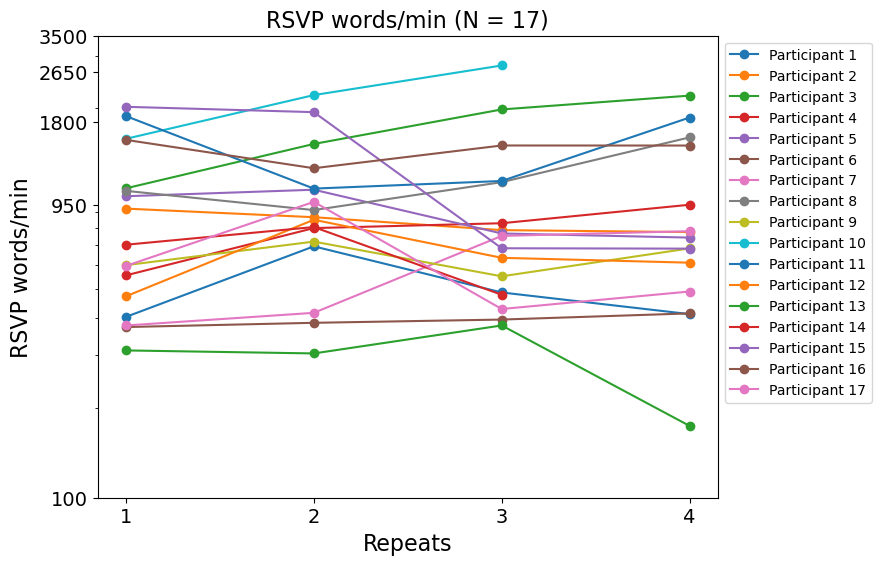

In [14]:
plot_thresholds(rsvp, var_name="RSVP words/min", ylims = [100, 3500])

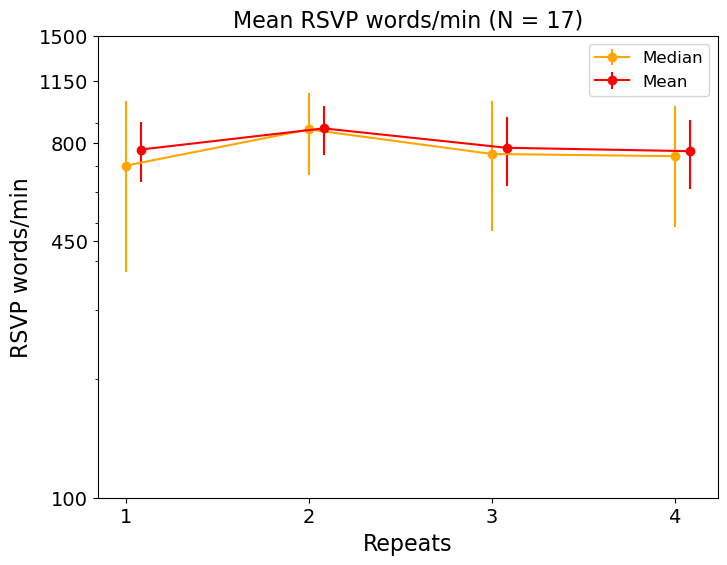

In [15]:
plot_mean_thresholds(rsvp, var_name="RSVP words/min", ylims = [100, 1500])

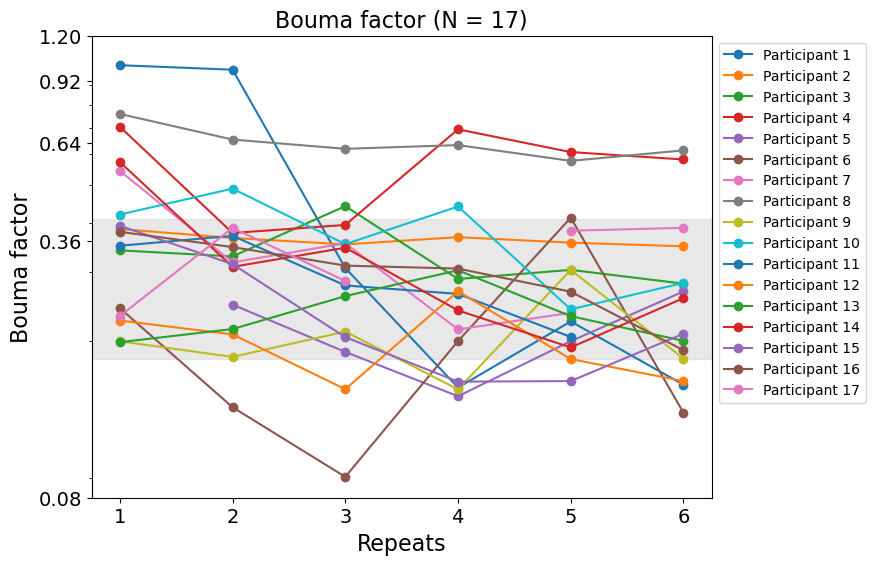

In [16]:
plot_thresholds(bouma, var_name="Bouma factor")

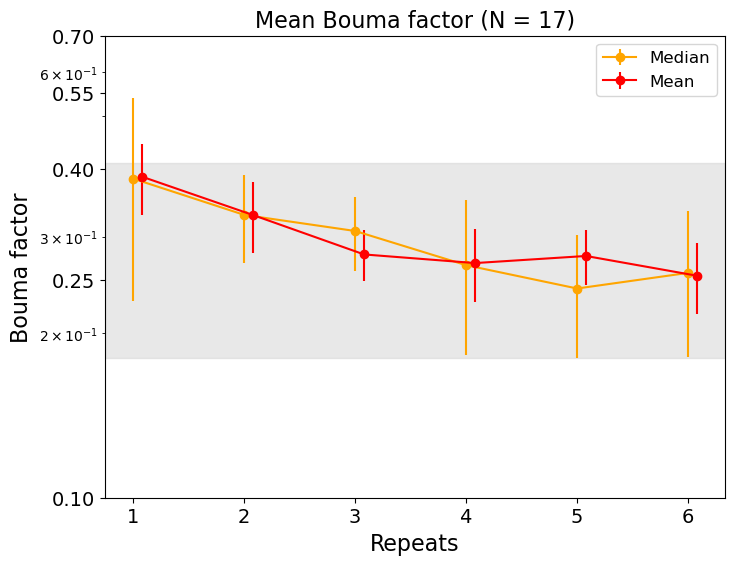

In [17]:
plot_mean_thresholds(bouma, var_name="Bouma factor", ylims = [.1, .7])

In [18]:
# print out mean values to show mean learning
bouma_mean = gmean(bouma, axis = 0, nan_policy='omit')
bouma_changes = np.array([bouma_mean[1] - bouma_mean[0], 
                          bouma_mean[2] - bouma_mean[1],
                          bouma_mean[3] - bouma_mean[2],
                          bouma_mean[4] - bouma_mean[3],
                          bouma_mean[5] - bouma_mean[4]])
print(gmean(bouma, axis = 0, nan_policy='omit'))
print(bouma_changes)

[0.38647689 0.32884701 0.27861417 0.26867495 0.27682222 0.25472594]
[-0.05762989 -0.05023283 -0.00993923  0.00814727 -0.02209628]


0.05393136020595482


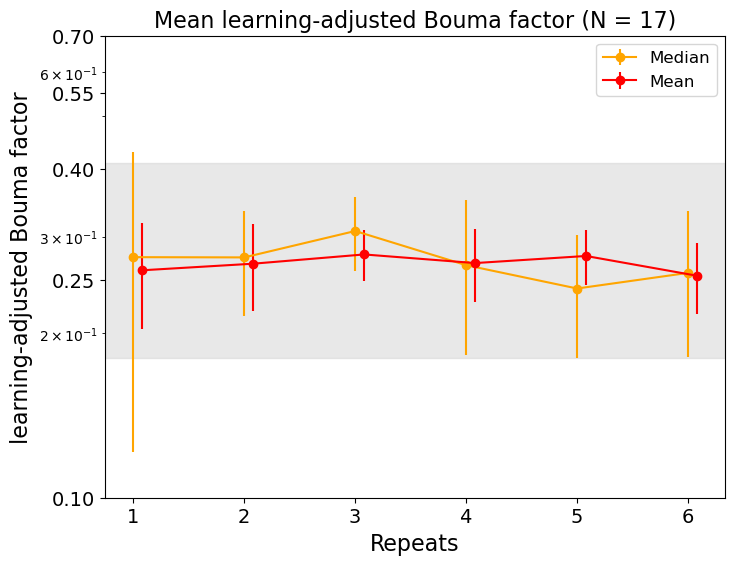

In [21]:
learning_factor_logCrowding = np.abs((bouma_changes[0] + bouma_changes[1])/2)
print(learning_factor_logCrowding)

# Add that to our bouma array
learning_adjusted_bouma = bouma.copy()
learning_adjusted_bouma.iloc[:, 0] -= 2 * learning_factor_logCrowding
learning_adjusted_bouma.iloc[:, 1] -= learning_factor_logCrowding

plot_mean_thresholds(learning_adjusted_bouma, var_name="learning-adjusted Bouma factor")

In [22]:
# rsvp parameters

mean_logRSVP = np.log10(np.mean(gmean(rsvp, axis = 0, nan_policy='omit')))
print("mean of log:", mean_logRSVP)

withinVar_logRSVP, betweenVar_logRSVP = compute_variances(np.log10(rsvp))
print("within var of log:", withinVar_logRSVP)
print("across var of log:", betweenVar_logRSVP)

mean of log: 2.900547193823127
within var of log: 0.015716195254670717
across var of log: 0.05576720685983309


In [23]:
# crowding parameters

mean_logCrowding = np.log10(np.mean(gmean(bouma, axis = 0, nan_policy='omit')))
print("mean of log:", mean_logCrowding)

withinVar_logCrowding, betweenVar_logCrowding = compute_variances(np.log10(learning_adjusted_bouma))
print("within var of log:", withinVar_logCrowding)
print("across var of log:", betweenVar_logCrowding)

mean of log: -0.524289794396922
within var of log: 0.024846528192488497
across var of log: 0.02779599805351727


In [24]:
within_indiv_var, across_indiv_var = compute_variances(log_bouma)
print("within var (before learning adj):", within_indiv_var)
print("across var (before learning adj):", across_indiv_var)

within var (before learning adj): 0.022222534507808235
across var (before learning adj): 0.022856768139028868


In [25]:
np.mean(gmean(bouma, axis = 0, nan_policy='omit'))

0.29902686354735186

## Functions for simulations

In [215]:
class def_variable_parameters:
    
    def __init__(self, betweenVar, withinVar, mean, learning_factor):
        self.ObsVar = betweenVar
        self.MeasVar = withinVar
        self.Mean = mean
        self.learning_factor = learning_factor

In [216]:
def simulate_psychophysics_data(crowding_params, rsvp_params, n_samples=100, n_measurements=6, correlation = -0.7):
    '''
    Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
    for specified number of samples and measurements per sample for each task
    
    Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
    and the mean of those measurements for each "participant" (sample)
    
    # Parameters for the simulation
    The two required inputs are two objects, 
    each containing the parameters of the x and the y components of this correlation simulation.
     '''

    # Covariance matrix for the "true" thresholds
    cov_matrix = np.array([
        [crowding_params.ObsVar, correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar)],
        [correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar), rsvp_params.ObsVar]
    ])

    # Simulate "true" thresholds for crowding and RSVP reading
    true_thresholds = np.random.multivariate_normal(
        mean=[crowding_params.Mean, rsvp_params.Mean],
        cov=cov_matrix,
        size=n_samples
    )

    # Extract "true" values for crowding and RSVP
    true_crowding = true_thresholds[:, 0]
    true_rsvp = true_thresholds[:, 1]

    # Initialize a dictionary to store measurements
    data = {
        'crowding_true': true_crowding,
        'rsvp_true': true_rsvp,
    }

    # Simulate noisy measurements for both tasks in a single loop
    # Account for learning in crowding task 
    crowding_measurements = []
    rsvp_measurements = []
    for i in range(n_measurements):
        crowding_noise = np.random.normal(0, np.sqrt(crowding_params.MeasVar), size=n_samples)
        rsvp_noise = np.random.normal(0, np.sqrt(rsvp_params.MeasVar), size=n_samples)
        
        # Calculate noisy measurements 
        crowding_measurement = true_crowding + crowding_noise
        rsvp_measurement = true_rsvp + rsvp_noise
        
        # Increase initial crowding thresholds by learning factor (since learning hasn't yet occurred)
        if i == 0:
            crowding_measurement += 2 * crowding_params.learning_factor
        if i == 1:
            crowding_measurement += crowding_params.learning_factor

        # Add individual measurements to the dictionary
        data[f'crowding_measurement{i+1}'] = crowding_measurement
        data[f'rsvp_measurement{i+1}'] = rsvp_measurement

        # Collect measurements for later averaging
        crowding_measurements.append(crowding_measurement)
        rsvp_measurements.append(rsvp_measurement)

    # Compute the averages of all measurements
    data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
    data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

    # Create and return the DataFrame
    simulation_data = pd.DataFrame(data)
    return simulation_data

Below we run the simulation 1,000 times for each combo of specified sample sizes and number of measurements. For each round we get the mean difference between the ground truth corr and the corrected corr (using Diedrichsen's noise ceiling method). Then we can plot resulting histograms.

In [254]:
def run_simulation(crowding_param, rsvp_param,
                   range_samples=[40, 80, 160, 320], range_measurements=[2, 4, 8, 16], n_repetitions=1000,
                   true_correlation = -0.6):   

    # Store results
    hist_corrected_corr = {}
    hist_measured_corr = {}
    results_corr = []

    for n_samples in range_samples:
        for n_meas in range_measurements:
            diff_list_measured = []
            diff_list_corrected = []

            for _ in range(n_repetitions):
                simulation_data = simulate_psychophysics_data(crowding_param, rsvp_param,
                                                              n_samples, n_meas, correlation = true_correlation)

                crowding_measurements = simulation_data[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                rsvp_measurements = simulation_data[[f'rsvp_measurement{i+1}' for i in range(n_meas)]]

                r_ceil_crowding = compute_noise_ceiling(crowding_measurements)
                r_ceil_rsvp = compute_noise_ceiling(rsvp_measurements)

                r_ceil = np.sqrt(r_ceil_crowding * r_ceil_rsvp)

                measured_corr, _ = pearsonr(simulation_data['crowding_measurement'], simulation_data['rsvp_measurement'])
                corrected_corr = measured_corr / r_ceil

                diff_list_measured.append(measured_corr - true_correlation)
                diff_list_corrected.append(corrected_corr - true_correlation)

            hist_measured_corr[(n_samples, n_meas)] = diff_list_measured
            hist_corrected_corr[(n_samples, n_meas)] = diff_list_corrected

            rmse_measured = np.sqrt(np.mean([x**2 for x in diff_list_measured])) 
            rmse_corrected = np.sqrt(np.mean([x**2 for x in diff_list_corrected]))

            mean_diff_measured = np.mean(diff_list_measured)
            mean_diff_corrected = np.mean(diff_list_corrected)

            sd_measured = np.std(diff_list_measured)
            sd_corrected = np.std(diff_list_corrected)

            ci_lower_measured, ci_upper_measured = norm.interval(0.95, loc=mean_diff_measured, 
                                                                 scale=np.std(diff_list_measured) / np.sqrt(n_repetitions))
            ci_lower_corrected, ci_upper_corrected = norm.interval(0.95, loc=mean_diff_corrected, 
                                                                   scale=np.std(diff_list_corrected) / np.sqrt(n_repetitions))

            results_corr.append({
                "n_samples": n_samples,
                "n_measurements": n_meas,

                "meanDiff_measured": mean_diff_measured,
                "rmse_measured": rmse_measured,
                "sd_measured": sd_measured,
                "ciLower_measured": ci_lower_measured,
                "ciUpper_measured": ci_upper_measured,

                "meanDiff_corrected": mean_diff_corrected,
                "rmse_corrected": rmse_corrected,
                "sd_corrected": sd_corrected,
                "ciLower_corrected": ci_lower_corrected,
                "ciUpper_corrected": ci_upper_corrected
            })

        print("done with n_samples =",n_samples)

    results_corr_df = pd.DataFrame(results_corr)
   
    return results_corr_df, hist_measured_corr, hist_corrected_corr 

## Functions for plotting the results

In [255]:
def plot_uncorrected_corrected(results_corr_df, x_values, x_subset_name, line_values, line_subset_name, line_label,
                              y_measured_name, y_corrected_name, 
                              x_label, y_label, colors):
    '''
    Inputs:
    - results_corr_df: data frame containing n_samples, n_measurements, and results 
                       such as rmse and sd associated with each number of samples/measurements
    - x_labels:        lists out what we are plotting on the x axis (e.g., n_samples, n_measurements);
    
    '''
    
    plt.figure(figsize=(10, 6))

    for i, ll in enumerate(line_values):
        subset = results_corr_df[results_corr_df[line_subset_name] == ll]

        color = colors[i]
        plt.errorbar(subset[x_subset_name], subset[y_measured_name],
                     fmt='-o', color=color, label=f"{ll} (Uncorrected)")
        plt.errorbar(subset[x_subset_name], subset[y_corrected_name],
                     fmt='--o', color=color, label=f"{ll} (Corrected)")

    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.ylim(-.02,0.25)
    plt.yticks(size=14)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=14)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # Keep only one legend entry per sample size
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    plt.legend(unique_handles, unique_labels, title=line_label, bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

    plt.tight_layout()
    plt.show()

In [256]:
def plot_sim_results(results_corr_df):
    
    sample_sizes = sorted(results_corr_df["n_samples"].unique())
    colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))  # Use colormap for distinct colors
    n_measurements = sorted(results_corr_df["n_measurements"].unique())

    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'rmse_measured', 'rmse_corrected', 
                                  'Number of measurements', 'RMSE', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'rmse_measured', 'rmse_corrected', 
                                  'Number of samples', 'RMSE', colors)


    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'meanDiff_measured', 'meanDiff_corrected', 
                                  'Number of measurements', 'Mean difference', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'meanDiff_measured', 'meanDiff_corrected', 
                                  'Number of samples', 'Mean difference', colors)

    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'sd_measured', 'sd_corrected', 
                                  'Number of measurements', 'SD', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'sd_measured', 'sd_corrected', 
                                  'Number of samples', 'SD', colors)

In [257]:
def plot_histograms(hist_corr, corr_type = "Uncorrected"):
    """
    Plots histograms of differences in correlation values for different sample and measurement conditions.
    
    Parameters:
    hist_corr (dict): A dictionary where keys are tuples (n_samples, n_measurements),
                      and values are lists/arrays of differences.
    corr_type (str): either "Uncorrected" or "Corrected"
    """
    for (n_samples, n_measurements), differences in hist_corr.items():
        mean_diff = np.mean(differences)
        sd = np.std(differences)

        plt.figure(figsize=(5, 4))
        plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')

        # Add vertical lines for mean and standard deviation
        plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
        plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
        plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
        plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

        # Formatting
        plt.xlim(-0.6, 0.6)
        plt.xlabel(f"{corr_type}-Sample R")
        plt.ylabel("Frequency")
        plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
        plt.legend()
        plt.show()

In [263]:
# Run simulation
crowding_param = def_variable_parameters(betweenVar = betweenVar_logCrowding, withinVar = withinVar_logCrowding, 
                                         mean = mean_logCrowding, learning_factor = learning_factor_logCrowding)

rsvp_param = def_variable_parameters(betweenVar = betweenVar_logRSVP, withinVar = withinVar_logRSVP, 
                                     mean = mean_logRSVP, learning_factor = 0)

results_corr_df, hist_measured_corr, hist_corrected_corr = run_simulation(crowding_param, rsvp_param)

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


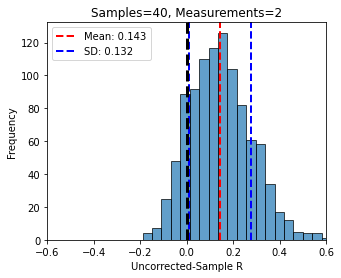

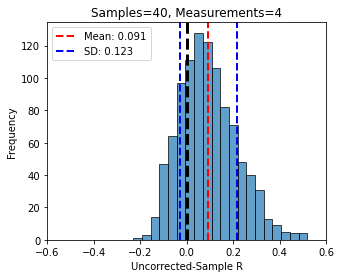

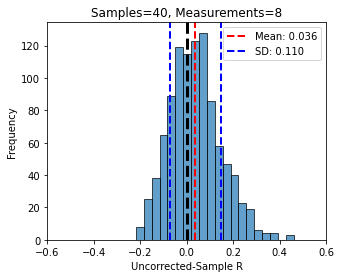

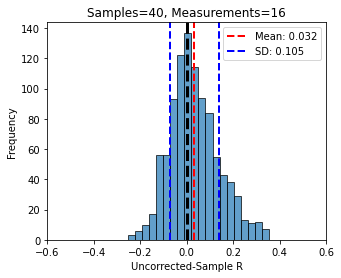

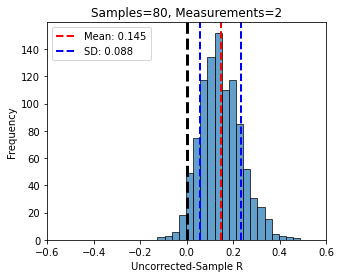

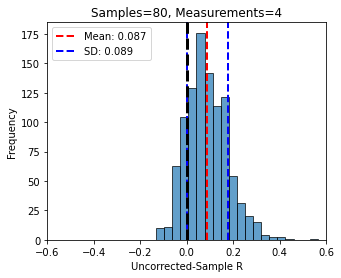

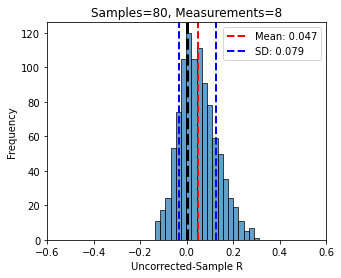

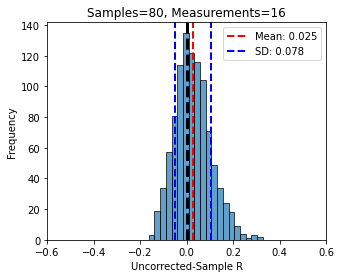

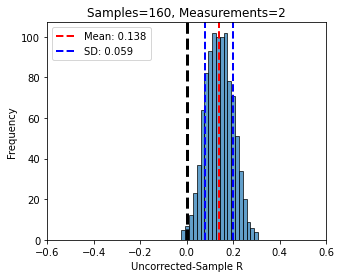

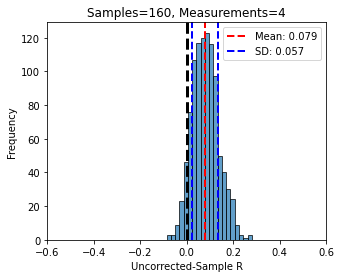

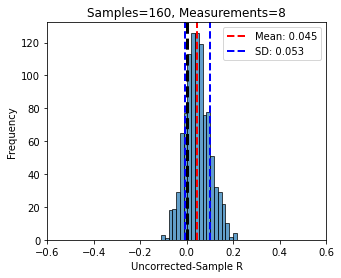

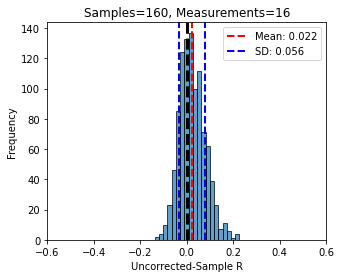

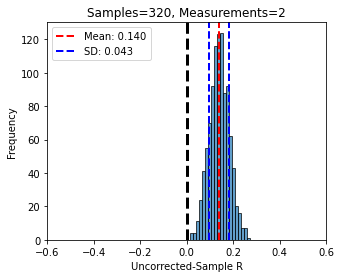

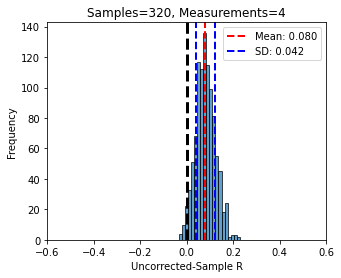

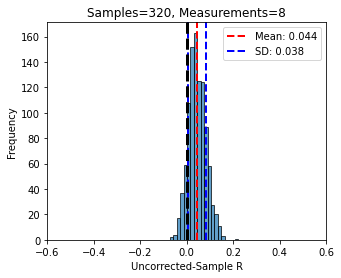

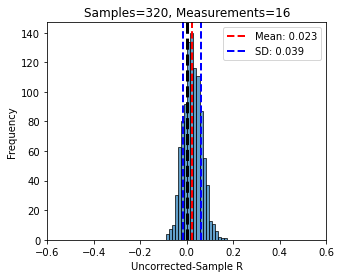

In [264]:
plot_histograms(hist_measured_corr, corr_type = "Uncorrected")

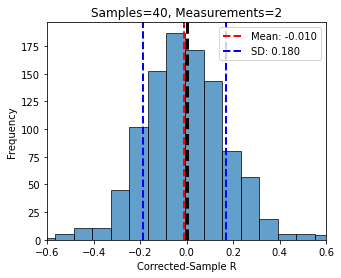

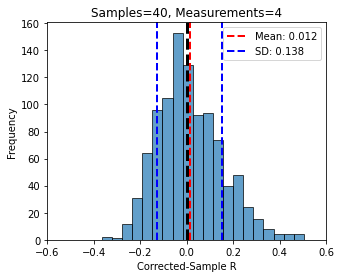

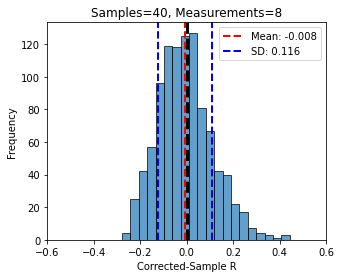

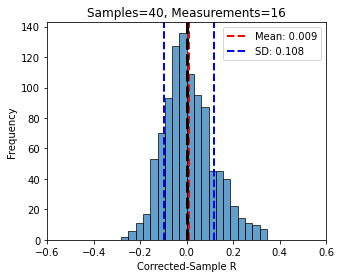

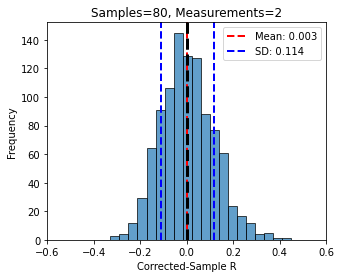

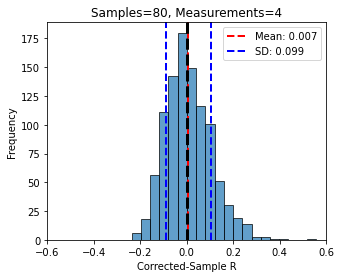

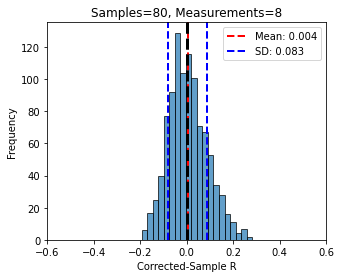

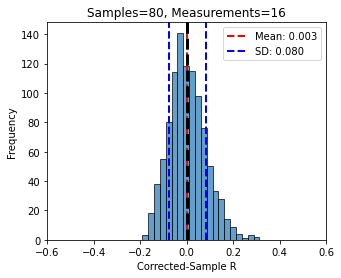

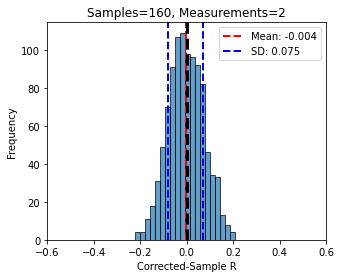

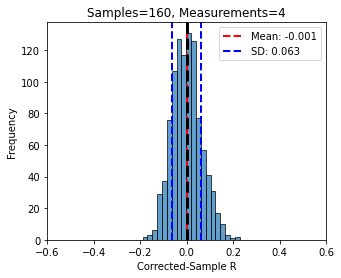

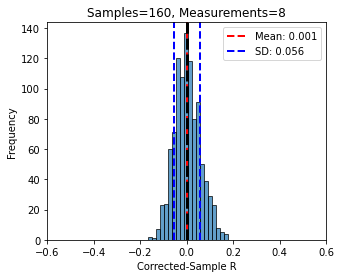

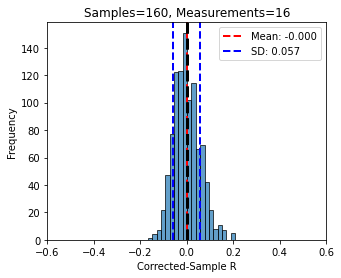

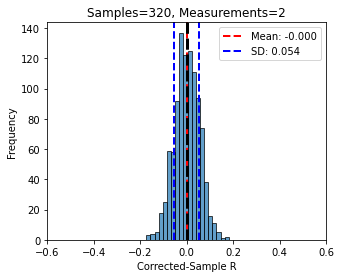

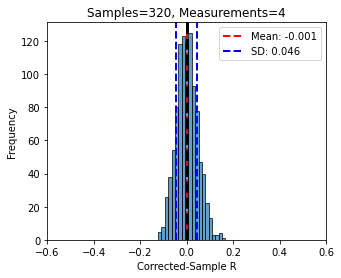

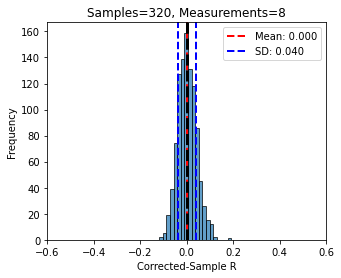

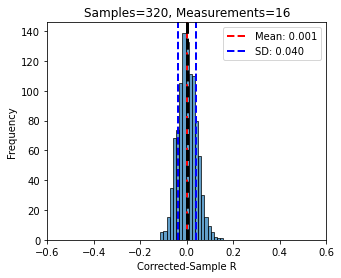

In [265]:
plot_histograms(hist_corrected_corr, corr_type = "Corrected")

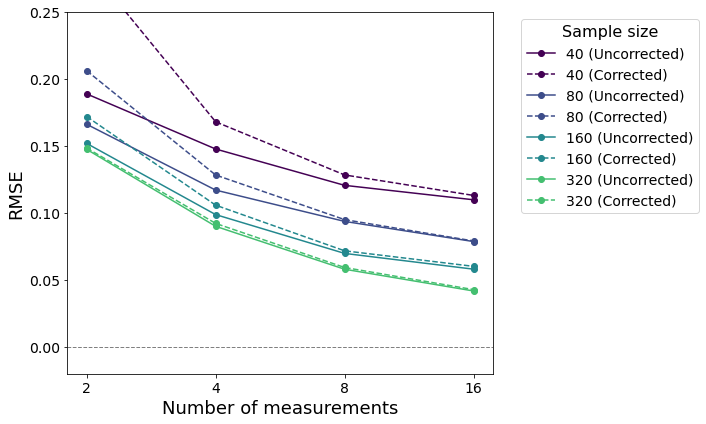

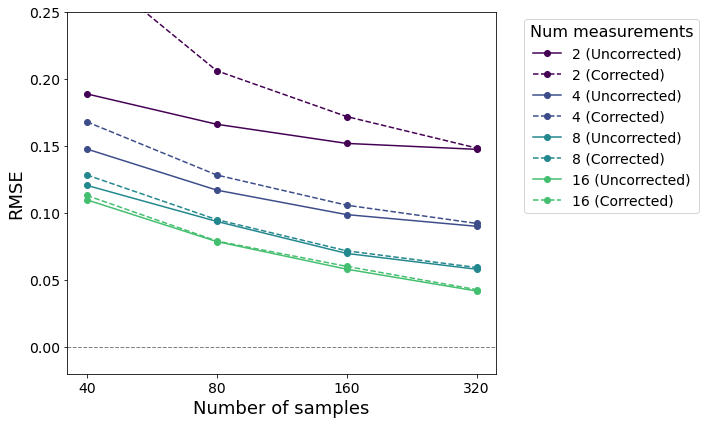

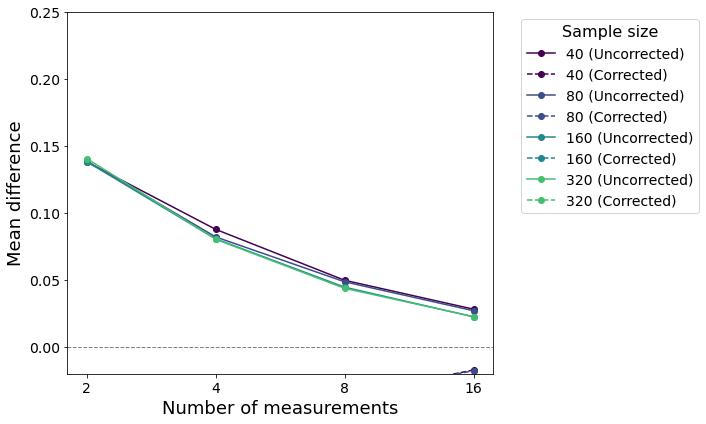

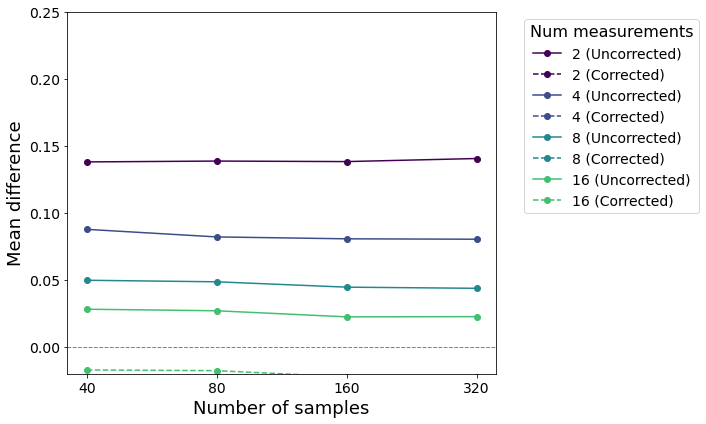

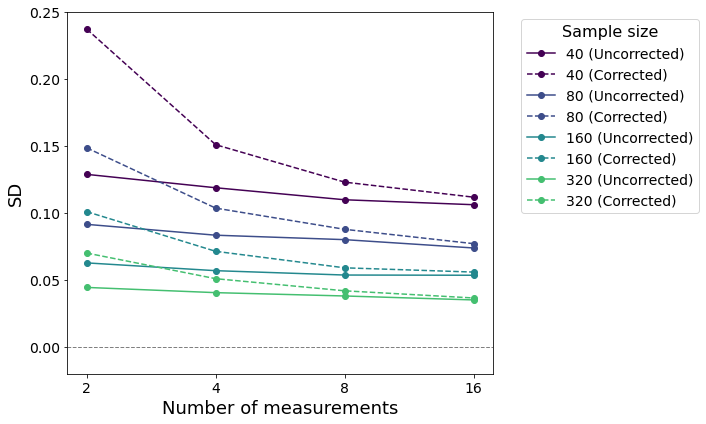

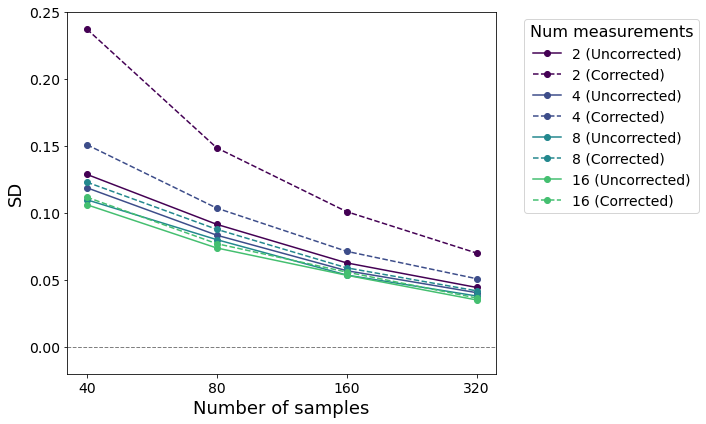

In [261]:
plot_sim_results(results_corr_df)